# MODELO EfficientNetB2 de KERAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

In [2]:
ruta_entrenamiento = './data/train/'
ruta_validacion = './data/val/'
ruta_prueba = './data/test/'

In [3]:
class_names = ["aloevera", "banana", "longbeans", "coconut", "corn", "cucumber", "curcuma", "eggplant", "galangal",
               "ginger", "mango", "melon", "orange", "papaya", "peperchili", "pineapple", "pomelo", "spinach",
               "sweetpotatoes", "watermelon"]

image_size = (224, 224)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

In [4]:
from sklearn.utils import shuffle

def read_data(path, im_size, class_names_label):
    X = []
    y = []

    for folder in os.listdir(path):
        label = class_names_label[folder]
        folder_path = os.path.join(path, folder)

        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, im_size)
            X.append(image)
            y.append(label)

    return np.array(X), np.array(y)

X_train, y_train = read_data(ruta_entrenamiento, image_size, class_names_label)
X_val, y_val = read_data(ruta_validacion, image_size, class_names_label)
X_test, y_test = read_data(ruta_prueba, image_size, class_names_label)

X_train, y_train = shuffle(X_train, y_train, random_state=42)


In [5]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB2



modelo_efficientnetb2 = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(modelo_efficientnetb2.output)

output = Dense(20, activation='softmax')(x)

modelo_efficientnetb2 = Model(inputs=modelo_efficientnetb2.input, outputs=output)

modelo_efficientnetb2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = './mejor_efficientnetb2.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [8]:
effnetb2 = modelo_efficientnetb2.fit(X_train, y_train_cat, epochs=3, validation_data=(X_val, y_val_cat), callbacks=[model_checkpoint_callback])

Epoch 1/3


438/438 [==============================] - ETA: 0s - loss: 0.7579 - accuracy: 0.7796
Epoch 1: val_accuracy improved from -inf to 0.86150, saving model to .\mejor_efficientnetb2.h5


c:\Users\alexe\anaconda3\envs\deep_learning_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 1304s 3s/step - loss: 0.7579 - accuracy: 0.7796 - val_loss: 0.4771 - val_accuracy: 0.8615
Epoch 2/3
438/438 [==============================] - ETA: 0s - loss: 0.3844 - accuracy: 0.8816
Epoch 2: val_accuracy did not improve from 0.86150
438/438 [==============================] - 1237s 3s/step - loss: 0.3844 - accuracy: 0.8816 - val_loss: 0.4618 - val_accuracy: 0.8610
Epoch 3/3
438/438 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9162
Epoch 3: val_accuracy improved from 0.86150 to 0.89300, saving model to .\mejor_efficientnetb2.h5
438/438 [==============================] - 1215s 3s/step - loss: 0.2662 - accuracy: 0.9162 - val_loss: 0.3972 - val_accuracy: 0.8930


In [9]:
from tensorflow.keras.models import load_model

modelo_efficientnetb2.save('modelo_efficientnetb2.h5')

test_loss, test_accuracy = modelo_efficientnetb2.evaluate(X_test, y_test_cat)
print(f'\nTest Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')

125/125 [==============================] - 82s 656ms/step - loss: 0.4262 - accuracy: 0.8863

Test Accuracy: 0.8863, Test Loss: 0.4262


In [10]:
best_model = load_model('mejor_efficientnetb2.h5')

y_prob = best_model.predict(X_test)

y_pred = np.argmax(y_prob, axis=1)

125/125 [==============================] - 90s 678ms/step


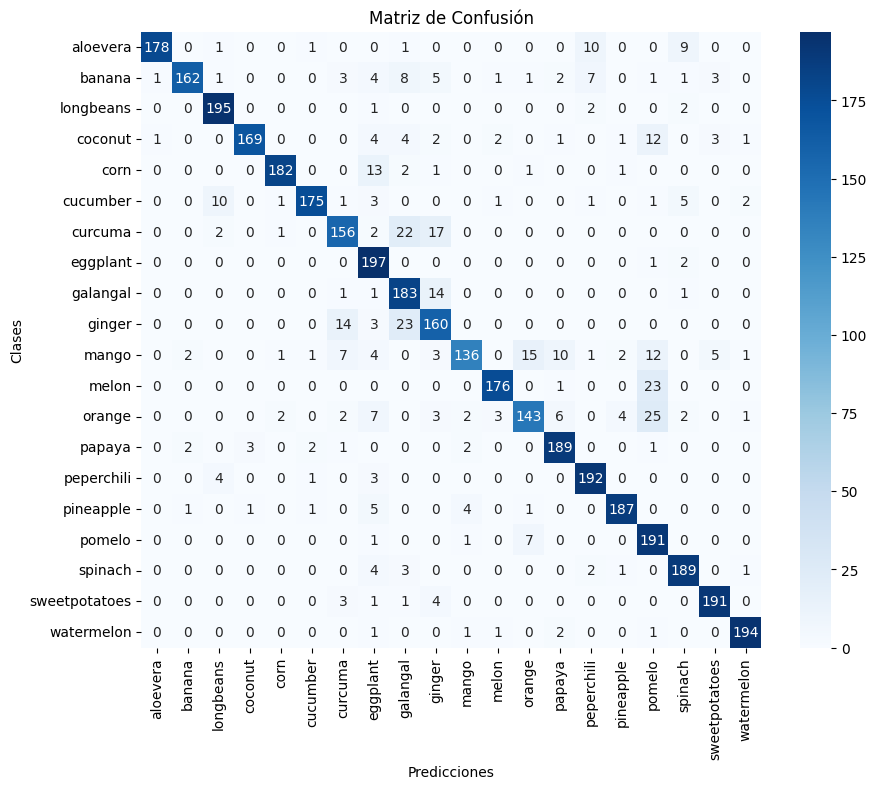

In [12]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Clases')
plt.show()